# Шишкин Александр Эдуардович, группа 0391, Лабораторная работа №3
Система с идентификацией параметров.

### 1. Модель системы и закон управления

$(1)\;\dot{dP}\;=\;17T\;+\;\zeta\;-\;0.1dP^3\;+\;9\sin\left(4dP\;-\;7\right)\;-\;6$

$(2)\;\dot T\;=\;-0.1T^3 - 2Tcos\left(5dP\;+\;6\right)\;+\;G\;*\;tanh\left(I\right)\;-\;1$

где:\
T - температура\
dP - изменение давления газа в резервуаре\
I - сила тока, протекающего через нагревательный элемент\
ζ ∈ [4;23] - некотролируемое возмущение в системе\
G - коэффициент усиления исполнительного механизма

In [1]:
import sympy
from sympy.solvers import solve
#создание символьных переменных
dP=sympy.symbols('dP')
T=sympy.symbols('T')
zeta0=sympy.symbols('zeta0')
I=sympy.symbols('I')
dP_d=sympy.symbols('dP_d')
G=sympy.symbols('G')
a = sympy.symbols('a')

#запись уравнений
d_dP=17 * T + zeta0 + a * dP**3 + 9 * sympy.sin(4 * dP - 7) - 6
dT=-0.1 * T**3 - 2 * T * sympy.cos(5 * dP + 6) + G * I - 1

d_dP_d=dP-dP_d

T_1 = sympy.symbols('T_1')
T_2 = sympy.symbols('T_2')

psi_1 = d_dP_d
dpsi_1 = sympy.diff(psi_1, dP)*d_dP
T_i = solve(sympy.expand(T_1*dpsi_1 + psi_1), T)[0]
print(f'T = {str(T_i)}')
psi_2 = T_i - T
dpsi_2 = sympy.diff(psi_2, dP)*d_dP + sympy.diff(psi_2,T)*dT
u = solve(sympy.expand(T_2*dpsi_2 + psi_2), I)
u_analytical = u[0]
print(f'psi_2 = {str(psi_2)}')
print(f'I = {str(u_analytical)}')

T = (T_1*(-a*dP**3 - zeta0 - 9*sin(4*dP - 7) + 6) - dP + dP_d)/(17*T_1)
psi_2 = -T + (T_1*(-a*dP**3 - zeta0 - 9*sin(4*dP - 7) + 6) - dP + dP_d)/(17*T_1)
I = 0.00588235294117647*(T_1*T_2*(17.0*T**3 - 510.0*T*a*dP**2 - 6120.0*T*cos(4.0*dP - 7.0) + 340.0*T*cos(5.0*dP + 6.0) - 30.0*a**2*dP**5 - 360.0*a*dP**3*cos(4.0*dP - 7.0) - 30.0*a*dP**2*zeta0 - 270.0*a*dP**2*sin(4.0*dP - 7.0) + 180.0*a*dP**2 - 360.0*zeta0*cos(4.0*dP - 7.0) - 1620.0*sin(8.0*dP - 14.0) + 2160.0*cos(4.0*dP - 7.0) + 170.0) + 10.0*T_1*(-17.0*T - a*dP**3 - zeta0 - 9.0*sin(4.0*dP - 7.0) + 6.0) + 10.0*T_2*(-17.0*T - a*dP**3 - zeta0 - 9.0*sin(4.0*dP - 7.0) + 6.0) - 10.0*dP + 10.0*dP_d)/(G*T_1*T_2)


### 2. Вспомогательные модули для моделирования


Импорт внешних модулей

In [2]:
!pip install digicon_mod

In [3]:
import math
import numpy
import matplotlib.pyplot as plt
import sklearn.linear_model as linmod

import digicon_mod

Правая часть дифференциального уравнения объекта со ступенчатым изменением параметра

In [4]:
def F_with_change(step_time, init_value, finish_value):
    def F_with_control(uc):
        def F_internal(x, t):
            if t > step_time:
                zeta = finish_value
            else:
                zeta = init_value
            d_dP=17 * x[1] + zeta - 0.1 * math.pow(x[0],3) + 9 * math.sin(4 * x[0] - 7) - 6
            dT=-0.1 * math.pow(x[1],3) - 2 * x[1] * math.cos(5 * x[0] + 6) + uc - 1
            return [d_dP, dT]

        return F_internal
    return F_with_control

Вывод результатов моделирования

In [5]:
def plot_result(time, time_end, x1, x2, plc, goal):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(time,x1, 'r-', time, x2, 'b-')
    plt.plot([0, time_end], [goal, goal], color='#FF0000',linestyle='--')
    plt.subplot(1,2,2)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(plc.t, plc.u,'b-',plc.t,plc.u_lim,'r-')
    plt.plot([0, tk], [1, 1], 'r--',[0, tk], [-1, -1], 'r--',[0, tk],[0, 0],'r:')
    plt.ylim([-2.0, 2.0])
    plt.show()

####3. Моделирование САУ с адаптивным регулятором идентификационного типа

Реализация алгоритма адаптивного управления на основе идентификации неизвестных параметров модели использует следующие идеи:

- расширение размерности исходной системы с целью устранения нелинейностей модели (новые переменные это нелинейные функции показаний датчика);
- формирование линейной модели процесса в расширенном пространстве переменных;
- накопление истории измерений фиксированной длинны внутри контроллера;
- использование метода наименьших квадратов для вычисления параметров линейной модели процеса;
- подстановка полученных параметров в функцию управления, полученную по методу АКАР.

Постановка задачи идентификации на основе модели линейной регрессии


$(1)\;\dot{dP}\;=\;17T\;+\;\zeta\;-\;\theta * dP^3\;+\;9\sin\left(4dP\;-\;7\right)\;-\;6$

$y = a\,x + b, \,\, y=\dot {dP} - 17T - 9\sin\left(4dP - 7\right)+ 6, \,\, x = dP^3, \,\, a = \theta, \,\, b=\zeta,\,\, \dot {dP_k} \approx \frac{dP_k - dP_{k-1}}{\Delta t}$

Реализация адаптивного регулятора (см. пакет sklearn
https://scikit-learn.org/stable/)

In [6]:
print(list(u_analytical.free_symbols))

[zeta0, G, T_1, dP, a, T_2, T, dP_d]


In [9]:
class ADCS_ident(digicon_mod.plc.PLC):
    def __init__(self, goal, gain, dt):
        super(ADCS_ident,self).__init__(gain, dt)
        self.G = gain
        self.dP_d = goal
        self.x_history = []
        self.x_history_len = 30
        self.dt = dt
        self.coeff = {'t':[0.0], 'a':[0.0], 'b':[0.0]}
        self.func = sympy.lambdify(list(u_analytical.free_symbols), u_analytical)

    def transform(self, x, t):
        return [x[0], x[1], math.pow(x[0],3.0), math.sin(4*x[0]-7)]

    def identification(self, x, t):
        self.x_history.append(x)
        if len(self.x_history) > self.x_history_len:
            self.x_history.pop(0)
        if len(self.x_history) > 1:
            z = numpy.array([self.transform(zi, t) for zi in (numpy.array(self.x_history)[:-1])])
            y = numpy.diff(numpy.array(self.x_history),axis=0)/self.dt
            #уравнение для y, подставляем производную измерения dP /*y[:,0]*/ и значения из вектора измерений z
            y1 = y[:,0] - 17*z[:,1] - 9*z[:,3]
            model = linmod.LinearRegression()
            model.fit(X=z[:,2].reshape(-1,1), y=y1)
            self.coeff['t'].append(t)
            a = model.coef_
            if isinstance(a, numpy.ndarray):
              a = a[0]
            self.coeff['a'].append(a)
            self.coeff['b'].append(model.intercept_)

    def control(self, x, t):
        self.identification(x, t)
        zeta0 = self.coeff['b'][-1]
        a = self.coeff['a'][-1]
        dP = x[0]
        G = self.gain
        T = x[1]
        dP_d = self.dP_d
        u = self.func(
            T_1=10.0, dP=dP, T=T, dP_d=dP_d, G=G, T_2=1.0, a=a, zeta0=zeta0
        )
        return u


Тест регулятора

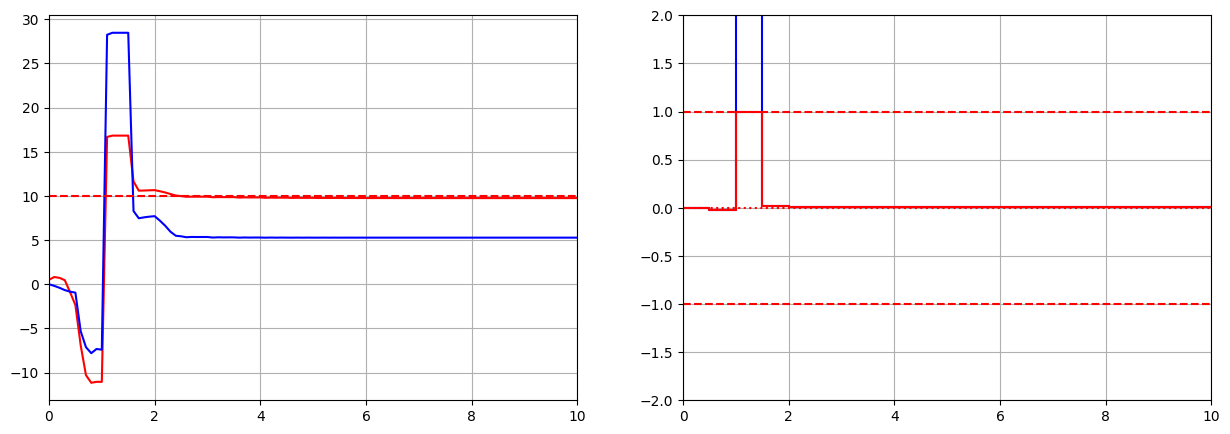

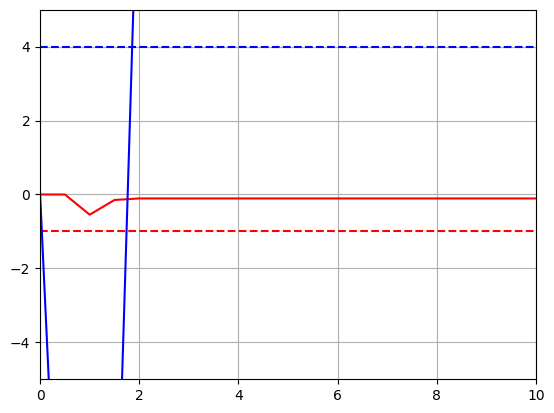

In [33]:
v0_init = 4.0
v0_finish = 23.0
change_time = 30
goal = 10
gain = 2300
step = 0.5
mod_step = 0.1
tk = 10
x0 = [0.5, 0.0]
func_ctrl = F_with_change(change_time,v0_init,v0_finish)

reg = ADCS_ident(goal=goal, gain=gain, dt=step)
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=goal)

tend = tk
plt.figure()
plt.plot(reg.coeff['t'], reg.coeff['a'], 'r', [0, tk], [-1, -1], 'r--',
         reg.coeff['t'], reg.coeff['b'], 'b', [0, change_time, change_time, tk], [v0_init, v0_init, v0_finish, v0_finish], 'b--')
plt.ylim([-5.0, 5.0])
plt.xlim([0, tk])
plt.grid()
plt.show()